In [3]:
import gym
import random
import os
import numpy as np
from collections      import deque
from keras.models     import Sequential
from keras.layers     import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [4]:
class Agent():
    def __init__(self, state_size, action_size):
        self.state_size         = state_size
        self.action_size        = action_size
        self.memory             = deque(maxlen=2000)
        self.learning_rate      = 0.001
        self.gamma              = 0.95
        self.exploration_rate   = 1.0
        self.exploration_min    = 0.01
        self.exploration_decay  = 0.995
        self.brain              = self._build_model()
    #exploration_decay permet de faire de moins en moins d'aléatoire
    #Avec epsilon = 1 et decay = 0,995, on commence par uniquement de l'exploration
    #On obtient epsilon = 0,01 au bout de 450 episodes environ et 0,01 au bout de 900 environ (ensuite on reste à 0,01)

    def _build_model(self):
      #réseau de neurones
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model


    def act(self, state):
        if np.random.rand() <= self.exploration_rate:
            return random.randrange(self.action_size)
        act_values = self.brain.predict(state)
        return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, sample_batch_size):
        if len(self.memory) < sample_batch_size:
            return
        sample_batch = random.sample(self.memory, sample_batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
              target = reward + self.gamma * np.amax(self.brain.predict(next_state)[0])
            target_f = self.brain.predict(state)
            target_f[0][action] = target
            self.brain.fit(state, target_f, epochs=1, verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

class CartPole:
    def __init__(self, episodes):
        self.sample_batch_size = 32
        self.episodes          = episodes
        self.env               = gym.make('CartPole-v1')
        self.state_size        = self.env.observation_space.shape[0]
        self.action_size       = self.env.action_space.n
        self.agent             = Agent(self.state_size, self.action_size)


    def run(self):
        rewards = []
        for index_episode in range(self.episodes):
            total = 0
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])

            done = False
            index = 0
            while not done:
                action = self.agent.act(state)
                next_state, reward, done, _ = self.env.step(action)
                total += reward
                next_state = np.reshape(next_state, [1, self.state_size])
                self.agent.remember(state, action, reward, next_state, done)
                state = next_state
                index += 1
            print("Episode {}# Score: {}".format(index_episode, index + 1))
            self.agent.replay(self.sample_batch_size)
            rewards.append(total)
        return rewards

In [13]:
cartpole = CartPole(episodes = 1000)
rewards = cartpole.run()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Episode 0# Score: 65
Episode 1# Score: 46
Episode 2# Score: 17
Episode 3# Score: 26
Episode 4# Score: 20
Episode 5# Score: 37
Episode 6# Score: 22
Episode 7# Score: 15
Episode 8# Score: 11
Episode 9# Score: 19
Episode 10# Score: 19
Episode 11# Score: 15
Episode 12# Score: 31
Episode 13# Score: 64
Episode 14# Score: 19
Episode 15# Score: 16
Episode 16# Score: 19
Episode 17# Score: 11
Episode 18# Score: 24
Episode 19# Score: 13
Episode 20# Score: 10
Episode 21# Score: 23
Episode 22# Score: 22
Episode 23# Score: 24
Episode 24# Score: 47
Episode 25# Score: 20
Episode 26# Score: 60
Episode 27# Score: 13
Episode 28# Score: 39
Episode 29# Score: 30
Episode 30# Score: 22
Episode 31# Score: 28
Episode 32# Score: 10
Episode 33# Score: 51
Episode 34# Score: 13
Episode 35# Score: 16
Episode 36# Score: 30
Episode 37# Score: 20
Episode 38# Score: 15
Episode 39# Score: 17
Episode 40# Score: 25
Episode 41# Score: 14
Episode 42# Score: 24
Episode 43# Score: 24
Episode 44# Score: 15
Episode 45# Score: 3

In [14]:
def runningAvg(data, windowSize):
  res = np.zeros(len(data)-windowSize)
  sum=0
  for i in range(windowSize):
    sum += data[i]
  for i in range(len(data)-windowSize):
    res[i]= sum/windowSize
    sum -= data[i]
    sum += data[i+windowSize]
  return res

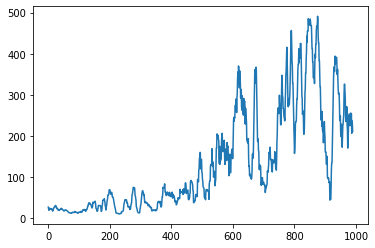

In [15]:
plt.plot(runningAvg(rewards, 10))

On observe que le robot a clairement appris. Il atteint très souvent le score maximum de 501. A la fin, le taux d'exploration est encore de 0,01 (donc un mouvement aléatoire une fois sur 100 environ) ce qui explique qu'on ait parfois des scores plutot faibles. Il faudrait exploiter ce que l'agorithme a appris (sans aléatoire pour constater les réelles performances) mais on sait déjà qu'elles seraient très bonnes.

In [16]:
"""
Cette fonction trouvée sur https://towardsdatascience.com/deep-q-learning-for-the-cartpole-44d761085c2f 
permet un plus joli affichage avec notamment la barre d'objectif à 200
"""

def plot_res(values, title=''):   
    ''' Plot the reward curve and histogram of results over time.'''
    # Update the window after each episode
    clear_output(wait=True)
    
    # Define the figure
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    f.suptitle(title)
    ax[0].plot(values, label='score per run')
    ax[0].axhline(195, c='red',ls='--', label='goal')
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Reward')
    x = range(len(values))
    ax[0].legend()
    # Calculate the trend
    try:
        z = np.polyfit(x, values, 1)
        p = np.poly1d(z)
        ax[0].plot(x,p(x),"--", label='trend')
    except:
        print('')
    
    # Plot the histogram of results
    ax[1].hist(values[-50:])
    ax[1].axvline(195, c='red', label='goal')
    ax[1].set_xlabel('Scores per Last 50 Episodes')
    ax[1].set_ylabel('Frequency')
    ax[1].legend()
    plt.show()

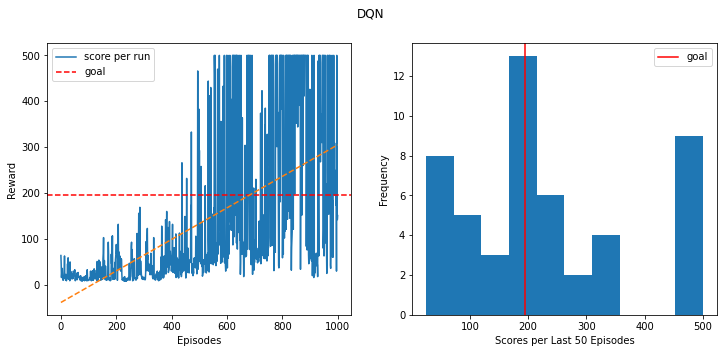

In [17]:
plot_res(rewards, 'DQN')